In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

In [13]:
# data transformation and augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                  for x in ['train', 'val']}

data_loaders = {x: torch.utils.data.DataLoader(dataset=image_datasets[x], 
                                               batch_size=4, 
                                               shuffle=True, 
                                               num_workers=4) 
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

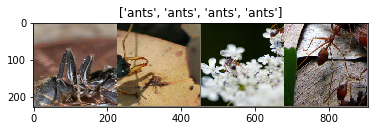

In [14]:
# visualize a few images
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose(1, 2, 0)
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

images, labels = next(iter(data_loaders['train']))

out = torchvision.utils.make_grid(images)

imshow(out, [class_names[x] for x in labels])

In [15]:
# train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {} / {}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        
        # each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        # iterate over data
        for inputs, labels in data_loaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum((preds == labels.data))
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
        print('{} loss: {:.4f} acc: {:4f}'.format(phase, epoch_loss, epoch_acc))
        
        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model        

In [16]:
# visualizing model predictions
def visualize_model(model, num_images=6):
    was_traing = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_traing)
                    return
        model.train(mode=was_traing)
        

In [22]:
# fine tuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
# train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 1 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 2 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 3 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 4 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 5 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 6 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 7 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 8 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 9 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 10 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 11 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 12 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 13 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 14 / 24
--------------------
val loss: 0.8130 acc: 0.470588
Epoch 15 / 24
------

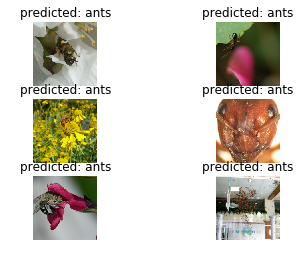

In [24]:
visualize_model(model_ft)

In [28]:
# convnet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(in_features=num_ftrs, out_features=2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# only the parameters of the final layer are optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# decay lr by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
# train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 1 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 2 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 3 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 4 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 5 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 6 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 7 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 8 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 9 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 10 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 11 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 12 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 13 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 14 / 24
--------------------
val loss: 0.7704 acc: 0.444444
Epoch 15 / 24
------

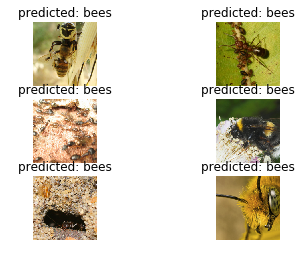

In [30]:
visualize_model(model_conv)

plt.ioff()
plt.show()